# Imports

In [1]:
# builtin
import os
import pandas as pd
import numpy as np
import time
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import manifold, decomposition

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Functions 

In [5]:
def image_preprocessing_for_cnn(path, image_name_col):
    
    images = []
    
    for filename in image_name_col:
        img = load_img(path+filename, target_size=(224, 224))  
        img = img_to_array(img) 
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        images.append(img)
    
    return images

# Import Data

In [6]:
os.listdir("data/source/") 

['data_image_product',
 'data_image_product_2',
 'flipkart_com-ecommerce_sample_1050.csv',
 'meteo_data_set',
 'P6_images_data_set']

In [7]:
os.listdir("data/cleaned")

['cleaned_data_to_analize_dataset.csv',
 'cleaned_data_to_vectorize_dataset.csv',
 'special_tokens_map.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'vocab.txt']

In [8]:
path = "./data/cleaned/"
filename = "cleaned_data_to_vectorize_dataset.csv"
data = pd.read_csv(path + filename)
data.head()

,uniq_id,product_category_1,image,description_bow,description_bow_lem
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...


# Classification supervisée

## Préparation des données 

In [9]:
le = preprocessing.LabelEncoder()
le.fit(data["product_category_1"])
data["label"] = le.transform(data["product_category_1"])

In [42]:
path = "data/source/P6_images_data_set/"
img_name_col = data['image']
images = image_preprocessing_for_cnn(path, img_name_col)

In [43]:
images = np.array(images)
images = np.concatenate(images, axis=0)

In [44]:
# Data pour modèles de DeepLearning
X_cnn = images
y_cnn = to_categorical(data['label'])

In [45]:
print("X_cnn : ", X_cnn.shape)
print("y_cnn : " ,y_cnn.shape)

X_cnn :  (1050, 224, 224, 3)
y_cnn :  (1050, 7)


In [46]:
# one hot encoding des catégories 
y_cnn

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
# pour importer les features : calculés par vgg16 partie Image
with open('./data/features_extracted/vgg16_Features.npy', 'rb') as f:
    features_vgg16 = np.load(f, allow_pickle=True)

In [22]:
print("Dimensions dataset avant réduction PCA : ", features_vgg16.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_vgg16 = pca.fit_transform(features_vgg16)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)


In [23]:
feat_pca_vgg16.shape

(1050, 940)

In [24]:
# Data pour modèles de Machine Learning
X_ml = feat_pca_vgg16
y_ml = le.transform(data["product_category_1"])

In [35]:
print("X_ml : ", X_ml.shape)
print("y_ml : " ,y_ml.shape)

X_ml :  (1050, 940)
y_ml :  (1050,)


**Scale des données**

In [65]:
from sklearn.model_selection import train_test_split , learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler= MinMaxScaler()
scaler_fit = scaler.fit(X_ml)
X_ml = scaler_fit.transform(X_ml)

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, stratify=y_ml, test_size=0.30, random_state= 101)


In [37]:
print("X_train : ", X_train.shape)
print("y_train : " ,y_train.shape)
print("")
print("X_test : ", X_test.shape)
print("y_test : " ,y_test.shape)

X_train :  (735, 940)
y_train :  (735,)

X_test :  (315, 940)
y_test :  (315,)


### Comparaison modèles 

In [28]:
# Decision Trees
from sklearn import tree
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# K-Nearest Neighbor(KNN)
from sklearn.neighbors import KNeighborsClassifier
# Adaboost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [29]:
descion_tress_cls = DecisionTreeClassifier(max_depth=2)
models_ = {'KNN':KNeighborsClassifier(n_neighbors=15),
           'LOG' : LogisticRegression(C=10,penalty='l2', solver='newton-cg'),
           'DecisionTree':tree.DecisionTreeClassifier(max_depth=20,criterion='gini'),
           'Adaboost':AdaBoostClassifier(n_estimators=20, base_estimator= descion_tress_cls ,learning_rate=0.01)    
          }

In [123]:
# Initialisation : 
# Metrics pour la cross validation
metrics_=['f1_weighted']
# Nombre de folds
k = 10
def compare_models(X_tr, 
                   y_tr,
                   X_te,
                   y_te,
                   models,
                   k, 
                   return_metrics= False ,
                   metrics = None, 
                  cross_val = False
                  ):
    
    """
    compare_models : une fonction qui permet de : 
    - Calculer R2, MSE, RMSE, et TIME du model
    - Comparer les metrics entre plusieurs models
    - Validation croisé sur les models
     
    """

    # Définir le nombre de Kfolds de la validation croisée
#     cv = KFold(n_splits=k)
    cv = KFold(n_splits=k, shuffle=True, random_state=0)
    acc_train = []
    acc_test = []
    F1_sco = []
    names = []
    TIME = []

    if return_metrics:
        
        # Itération sur les modèles _ cross_validation 
        for model in list(models.values()):


            # Cross validation score
            results_f1_w = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='f1_weighted')


            # Print Résultats
            print(f"{type(model).__name__}")
            print(f"CV F1_W_mean: {results_f1_w.mean().round(2)}")
            print(f"CV F1_W_Std:: {results_f1_w.std().round(2)}")
            print("-"*20)

            #Time Start: 
            start = time.time()
            # Fit_models
            model.fit(X_tr, y_tr)  
            # Predict
            y_pr = model.predict(X_te)

            # Clcul Metrics
            Accuracy_training = model.score(X_tr, y_tr)      
            Accuracy_testing = model.score(X_te, y_te)
            F_score = sk.metrics.f1_score(y_te, y_pr, average='weighted')


            # Append List
            acc_train.append(Accuracy_training)
            acc_test.append(Accuracy_testing)
            F1_sco.append(F_score)
            names.append(type(model).__name__)
            TIME.append(time.time() - start)

        metrics_model = pd.DataFrame({
            "Model": names,
            "F1_Score" : F1_sco,
            "Accuracy_Training": acc_train,
            "Accuracy_Testing": acc_test,
            "Time Taken": TIME
        })
        metrics_model = metrics_model.sort_values(by="F1_Score", ascending=False).set_index("Model")
        return metrics_model
        
    if cross_val:
        
        # Cross Validation    
        # Liste qui va contenir les résultats - une liste de dictionnaire
        dict_liste = []
        dict_scores = []
        for model_ in list(models.values()):
            # Compute the score for each fold
            cross_scores = cross_validate(model_,X_tr,y_tr,scoring = metrics_ ,cv=cv,return_train_score= True)

            # Calcul les moyennes de nos metrics_ et mettre les résultats dans dict_liste
            mean_scores = {metric:(np.mean(-cross_scores['test_'+ metric])) for metric in metrics_}

            mean_scores['Model'] = type(model_).__name__
            dict_liste.append(mean_scores)
            dict_scores.append(cross_scores)



        # Retourner les résultat de la validation croisée moyennes des metrics_                           
        cross_val_results = pd.DataFrame(dict_liste)
        cross_val_results = cross_val_results[['Model']+ metrics_]
        cross_val_results['F1_Score_W'] = -cross_val_results['f1_weighted'].round(2)
        del cross_val_results['f1_weighted']
        cross_val_results = cross_val_results.sort_values(by= "F1_Score_W", ascending=False)
        return cross_val_results
        #print('CV results: ', results)
    
     
        

In [124]:
compare_models(X_train, 
                   y_train,
                   X_test,
                   y_test,
                   models_,
                   k, 
                   return_metrics= True ,
                   metrics = None, 
#                   cross_val = False
                  )

KNeighborsClassifier
CV F1_W_mean: 0.04
CV F1_W_Std:: 0.02
--------------------
LogisticRegression
CV F1_W_mean: 0.51
CV F1_W_Std:: 0.07
--------------------
DecisionTreeClassifier
CV F1_W_mean: 0.61
CV F1_W_Std:: 0.06
--------------------
AdaBoostClassifier
CV F1_W_mean: 0.58
CV F1_W_Std:: 0.05
--------------------


,F1_Score,Accuracy_Training,Accuracy_Testing,Time Taken
Model,,,,
DecisionTreeClassifier,0.622939,1.000000,0.619048,0.502645
AdaBoostClassifier,0.590699,0.639456,0.622222,2.674692
LogisticRegression,0.460341,1.000000,0.453968,0.289123
KNeighborsClassifier,0.035714,0.148299,0.142857,0.092816


In [125]:
# validation croisé : cross_validate
compare_models(X_train, 
                   y_train,
                   X_test,
                   y_test,
                   models_,
                   k, 
                   return_metrics= False ,
                   metrics = None, 
                  cross_val = True
                  )

,Model,F1_Score_W
2,DecisionTreeClassifier,0.62
3,AdaBoostClassifier,0.58
1,LogisticRegression,0.51
0,KNeighborsClassifier,0.04


In [126]:
# Learning Curve graphique : 
def learning_curve_models(model, X_tr, y_tr):
    
               
    common_params = {
        "X": X_tr,
        "y": y_tr,
        "train_sizes": np.array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
        "cv": 5    
    }

    N, train_score, test_score,fit_times, _  = learning_curve(model, 
                                                X_tr, 
                                                y_tr,
                                                train_sizes= np.array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 
                                                cv=5, return_times=True,scoring = "f1_weighted" )
    train_mean = train_score.mean(axis=1)
    train_std = train_score.std(axis=1)
    test_mean = test_score.mean(axis=1)
    test_std = test_score.std(axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
    sns.set(style="whitegrid")
    
    
    # Plot learning curve
    plot = sns.lineplot(x=N, y=train_mean, label="Train", marker="o", ax=ax1)
    ax1.fill_between(N, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
        
    plot = sns.lineplot(x=N, y=test_mean, label="Validation", marker="o", ax=ax1)
    ax1.fill_between(N, test_mean - test_std, test_mean + test_std, alpha=0.1, color="orange")
    
    ax1.legend(loc="best")
    ax1.set_title(f" Learning curve {type(model).__name__}", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plot.set(xlabel="Training examples", ylabel="R2")
    
    
    # Plot Scalability of the model
    plot = sns.lineplot(x=fit_times_mean, y=test_mean, marker="o", ax=ax2)
    ax2.fill_between(fit_times_mean, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax2.set_title(f"Performance of the model : {type(model).__name__}", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plot.set(xlabel="Fit times examples", ylabel="R2")
    sns.despine(fig=fig)
    
    print("-"*20)
    print(type(model).__name__)
    print(f"train_score = {train_score.mean()}" )
    print(f"test_score = {test_score.mean()}")
    plt.show() 

In [127]:
# Fonction pour comparer plusieurs modèles 
def compare_fit_time_score(models, X_tr, y_tr):
    for model in list(models.values()):
        learning_curve_models(model, X_tr, y_tr) 

In [128]:
sk.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

--------------------
KNeighborsClassifier
train_score = 0.06588216051495607
test_score = 0.042092056502407965


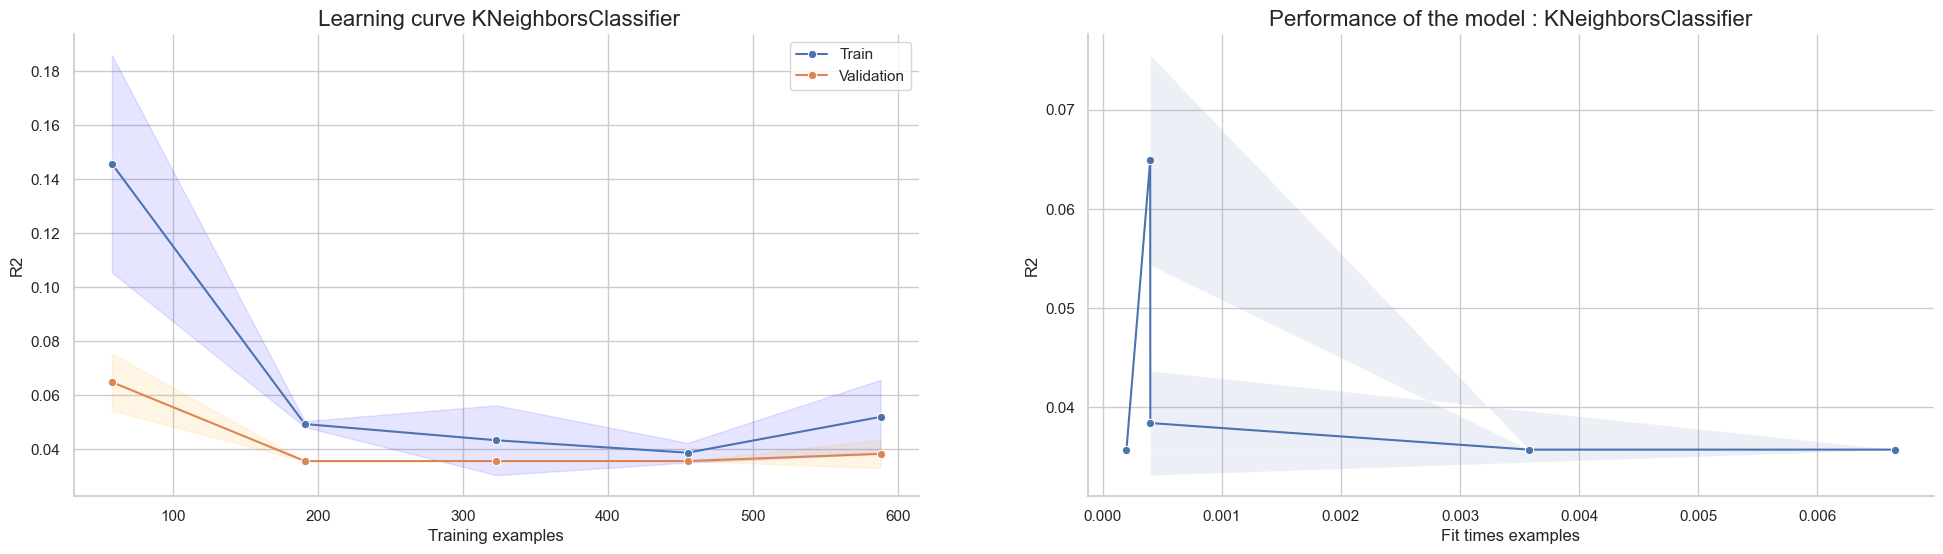

--------------------
LogisticRegression
train_score = 1.0
test_score = 0.36690224202256133


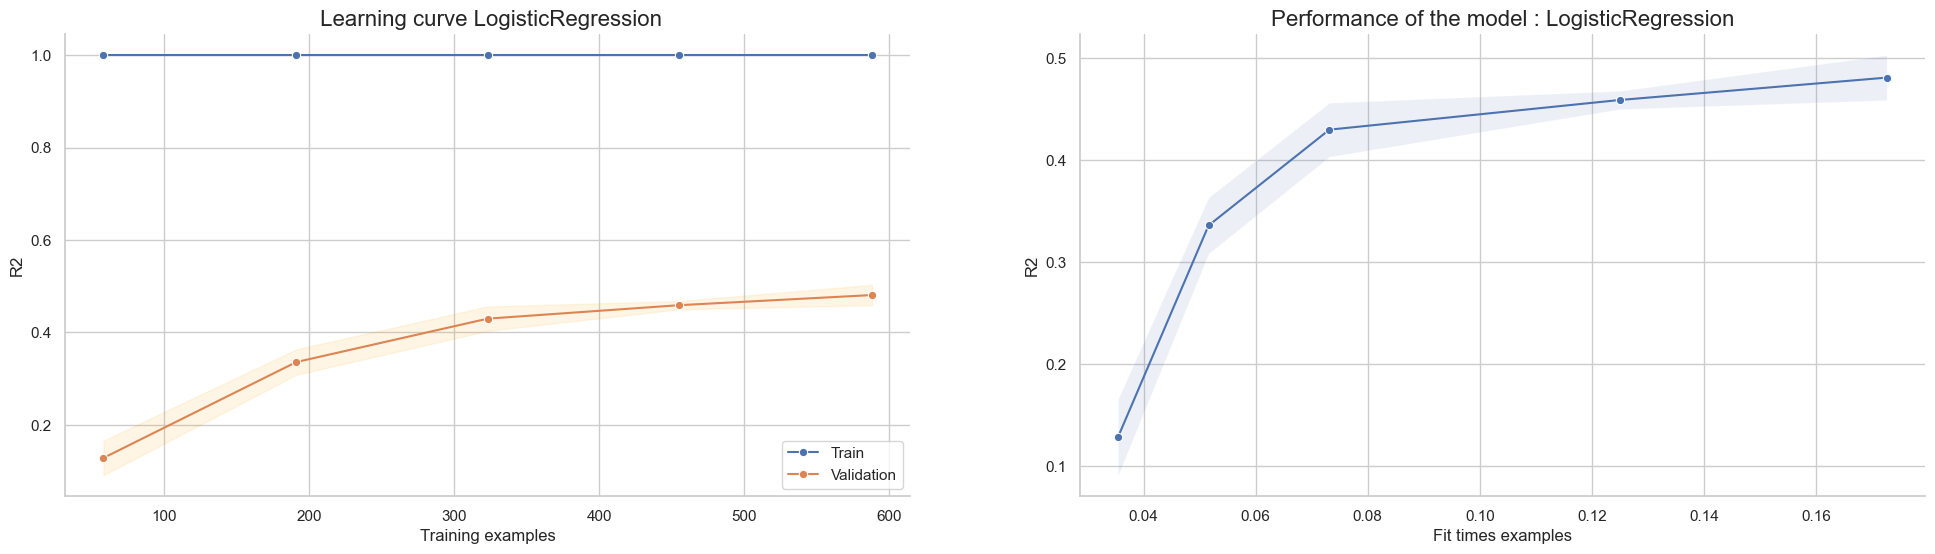

--------------------
DecisionTreeClassifier
train_score = 1.0
test_score = 0.5572506108595732


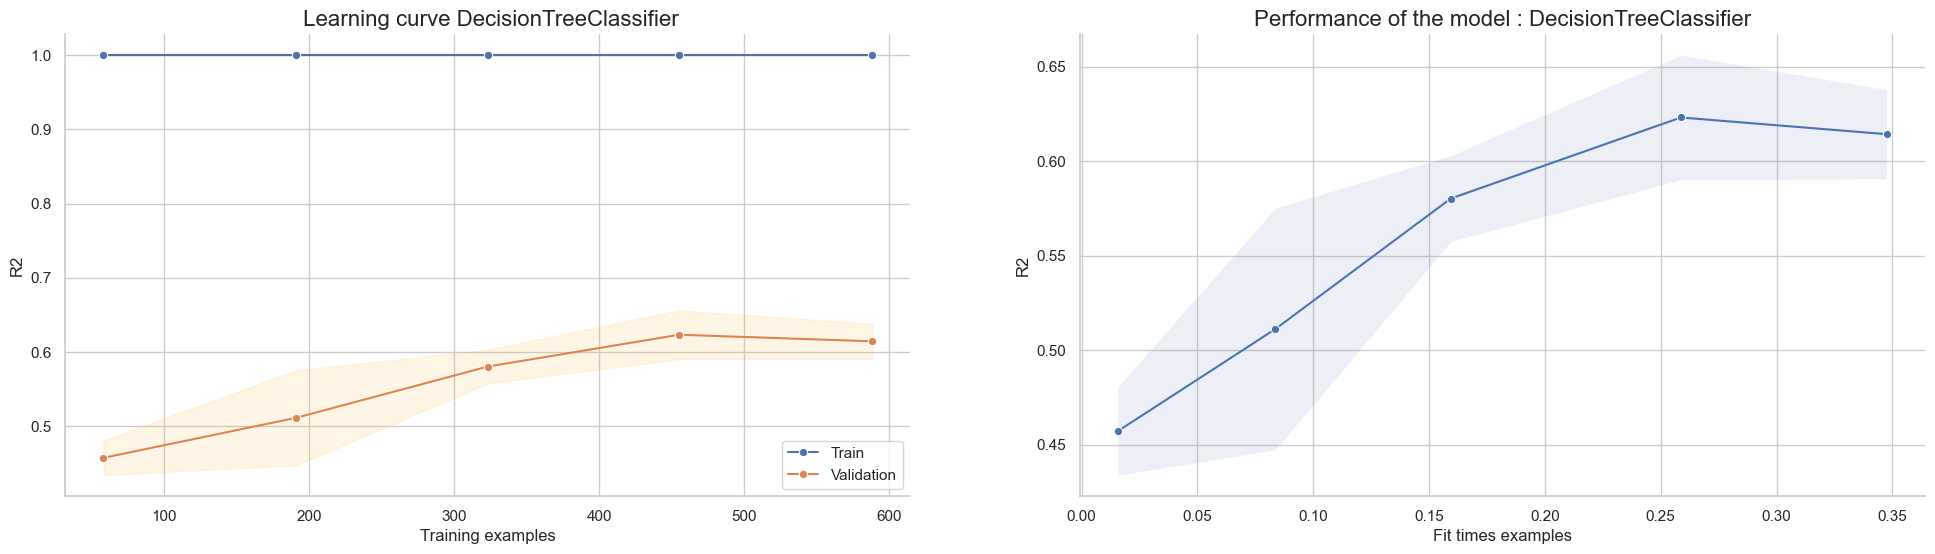

--------------------
AdaBoostClassifier
train_score = 0.7796059356461172
test_score = 0.5891967327180059


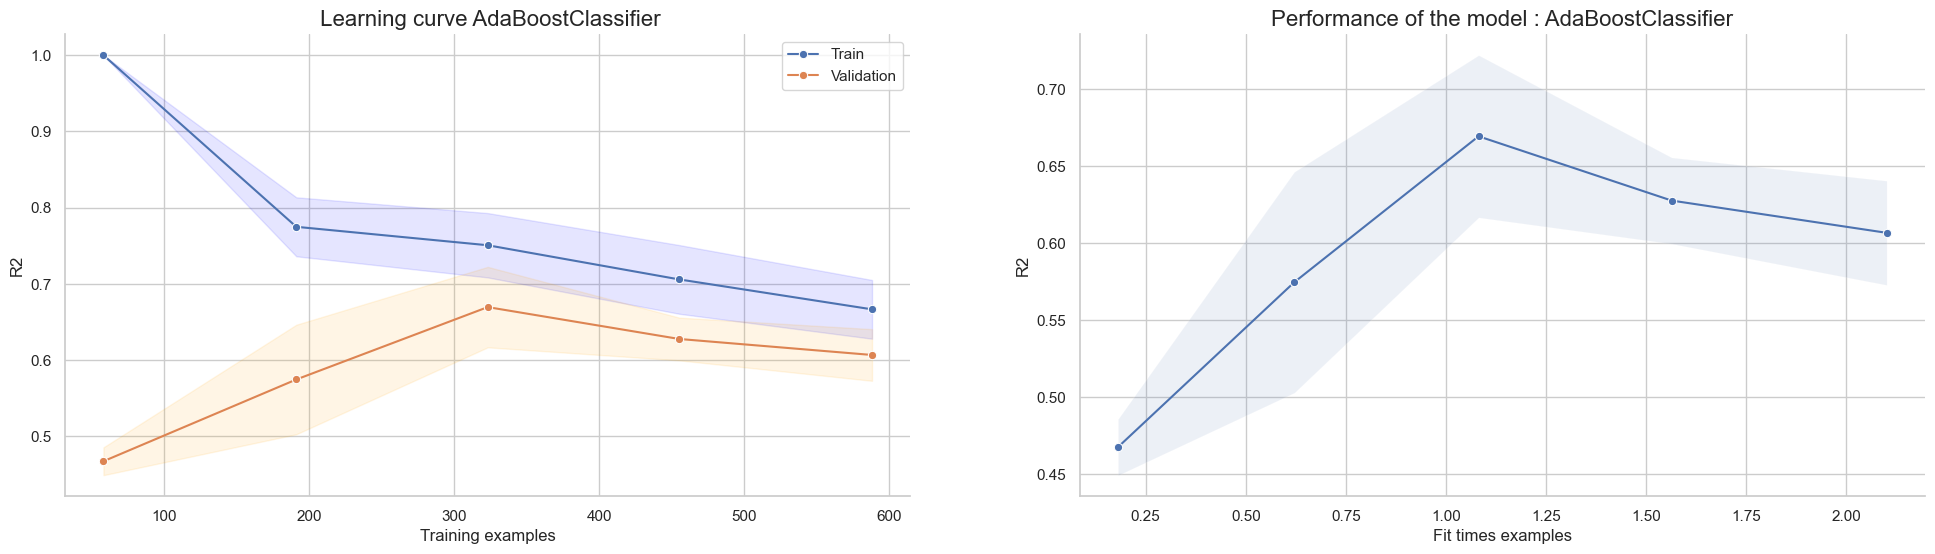

In [129]:
# Learning curve et fit time comparaison entre modèles. 
compare_fit_time_score(models_, X_train, y_train)

# Approche préparation initiale des images

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_cnn, stratify= y_cnn, test_size=0.30, random_state= 101)

In [48]:
print("X_train : ", X_train.shape)
print("y_train : " ,y_train.shape)

X_train :  (735, 224, 224, 3)
y_train :  (735, 7)


In [49]:
print("X_val : ", X_val.shape)
print("y_val : " ,y_val.shape)

X_val :  (315, 224, 224, 3)
y_val :  (315, 7)


**Construction du modèle**

In [94]:
from tensorflow import keras
from keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [93]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [135]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [136]:
# Création du callback
model1_save_path1 = "./data/model_calback/model1_best_weights.h5"

In [137]:
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [138]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=250, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/250
12/12 [==============================] - ETA: 0s - loss: 4.6996 - accuracy: 0.5061
Epoch 1: val_loss improved from inf to 1.32520, saving model to ./data/model_calback\model1_best_weights.h5
12/12 [==============================] - 6s 434ms/step - loss: 4.6996 - accuracy: 0.5061 - val_loss: 1.3252 - val_accuracy: 0.7397
Epoch 2/250
12/12 [==============================] - ETA: 0s - loss: 1.8134 - accuracy: 0.7102
Epoch 2: val_loss improved from 1.32520 to 1.16802, saving model to ./data/model_calback\model1_best_weights.h5
12/12 [==============================] - 5s 395ms/step - loss: 1.8134 - accuracy: 0.7102 - val_loss: 1.1680 - val_accuracy: 0.7810
Epoch 3/250
12/12 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.7687
Epoch 3: val_loss did not improve from 1.16802
12/12 [==============================] - 5s 391ms/step - loss: 1.2330 - accuracy: 0.7687 - val_loss: 1.3457 - val_accuracy: 0.7524
Epoch 4/250
12/12 [==============================] - ET

In [139]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print(f"Training Accuracy: {accuracy}")
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print(f"Validation Accuracy:  {accuracy}")

23/23 [==============================] - 4s 155ms/step - loss: 0.0089 - accuracy: 0.9973
Training Accuracy: 0.9972789287567139

10/10 [==============================] - 2s 152ms/step - loss: 0.9818 - accuracy: 0.8349
Validation Accuracy:  0.8349206447601318


In [140]:
# Score de l'epoch optimal
# model1.load_weights(model1_save_path1)

# loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
# print("Validation Accuracy :  {:.4f}".format(accuracy))

# loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy       :  {:.4f}".format(accuracy))


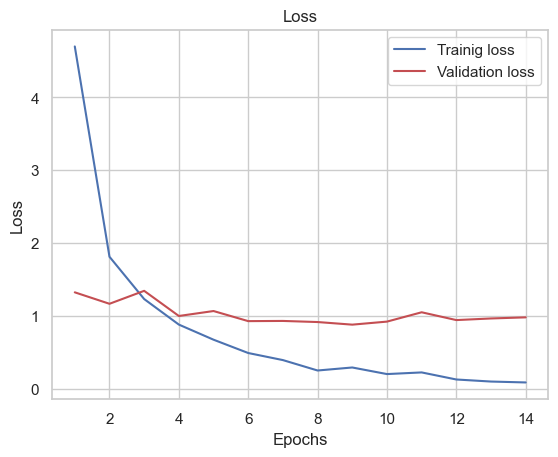

In [141]:
# plot training et validation accuracy pour chaque epochs
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title( "Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

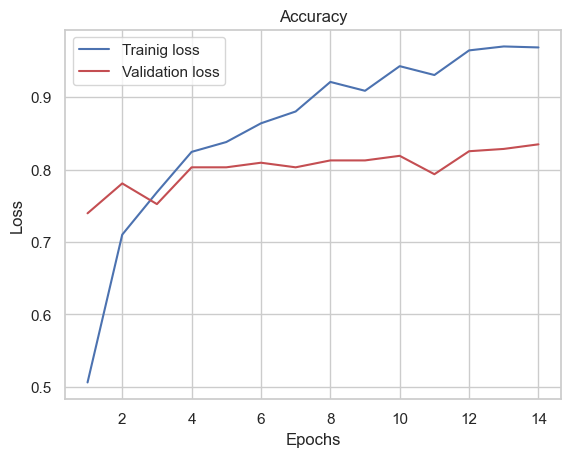

In [142]:
# plot training et validation accuracy pour chaque epochs
loss = history1.history['accuracy']
val_loss = history1.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title( "Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
# from plot_keras_history import show_history, plot_history
# import matplotlib.pyplot as plt
# show_history(history1)
# plot_history(history1, path="standard.png")
# plt.close()

In [144]:
# Prediction 
prediction = model1.predict(X_val)

10/10 [==============================] - 2s 150ms/step


In [145]:
pd.DataFrame(prediction.round(2))

,0,1,2,3,4,5,6
0,0.00,0.00,1.00,0.0,0.00,0.00,0.00
1,0.00,0.00,0.00,0.0,0.00,0.00,1.00
2,0.00,0.00,0.00,1.0,0.00,0.00,0.00
3,0.00,0.00,0.00,0.0,0.00,1.00,0.00
4,0.00,0.98,0.00,0.0,0.00,0.02,0.00
...,...,...,...,...,...,...,...
310,0.00,0.00,1.00,0.0,0.00,0.00,0.00
311,0.02,0.00,0.00,0.0,0.98,0.00,0.00
312,0.00,1.00,0.00,0.0,0.00,0.00,0.00
313,0.00,0.00,0.00,0.0,0.00,0.00,1.00


In [146]:
# Pour reconstituer les prédiction avec les noms de catégorie 
prediction_ = np.argmax(prediction, axis= -1)
prediction_ = le.inverse_transform(prediction_)
df_prediction = pd.DataFrame(prediction_)
df_prediction.head()

,0
0,Computers
1,Watches
2,Home Decor & Festive Needs
3,Kitchen & Dining
4,Beauty and Personal Care


In [147]:
def display_predicte_image_category(index_image):
    predicted_image_categorie = df_prediction[0][index_image]
    print('Predicted image category : ', predicted_image_categorie)
    img = X_val[index_image]
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted image category :  Watches


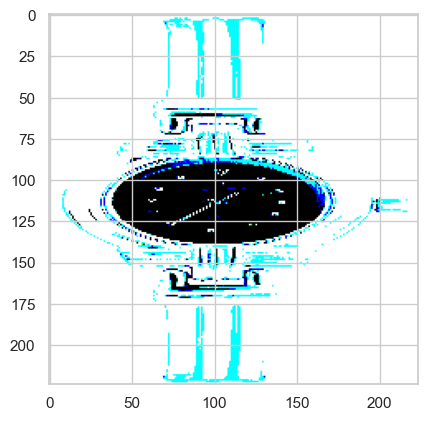

In [148]:
display_predicte_image_category(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted image category :  Kitchen & Dining


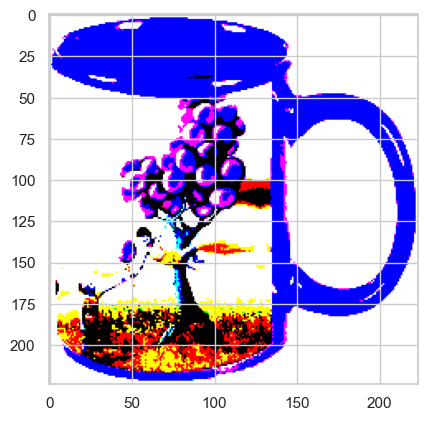

In [149]:
display_predicte_image_category(3)

# Approche par dataset Tesnorflow

## Préparation des données : 

Nous allons créer deux dossier train et test pour stocker les images qui vont nous servir à l'entrainement de nos modèles, dans un premier temps nous devons récupérer les indices des images du train set et du test set, pour ce faire : 

- on réalise un train_test_split. 
- on récupère les index des deux sets de données : train et test. 
- on dispatch les photos selon les index trouvés dans les différents dossiers et sous dossier. 

In [16]:
import glob
import shutil

In [71]:
X = data['image']
y = data['label']

In [72]:
X_train_, X_test_, _, _ = train_test_split(X, y, stratify=y, test_size=0.30, random_state= 101)

In [151]:
os.listdir('./data/source/P6_images_data_set/')

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

In [73]:
X_train_df = pd.DataFrame(X_train_)

In [81]:
# Liste des index du train set
liste_index_train = list(X_train_.index)
X_train_df.shape

(735, 1)

In [75]:
X_val_df = pd.DataFrame(X_test_)

In [80]:
X_val_df.shape

(315, 1)

In [79]:
# liste des index du test set
liste_index_test = list(X_val_df.index)

In [82]:
# Dossier qui vas contenir les photos
directory_name = "data_image_product_2"
parent_dir = "./data/source/"
path = os.path.join(parent_dir, directory_name)
os.mkdir(path)

In [83]:
# Directory Train
directory_name = "train"
parent_dir = "./data/source/data_image_product_2/"
path = os.path.join(parent_dir, directory_name)
os.mkdir(path)

In [84]:
# Directory Validation
directory_name = "test"
parent_dir = "./data/source/data_image_product_2/"
path = os.path.join(parent_dir, directory_name)
os.mkdir(path)

In [85]:
liste_categ = list(data['product_category_1'].unique())
parent_dir = "./data/source/data_image_product_2/train/"
for elm in liste_categ:
    path = os.path.join(parent_dir, elm)
    os.mkdir(path)

In [86]:
liste_categ = list(data['product_category_1'].unique())
parent_dir = "./data/source/data_image_product_2/test/"
for elm in liste_categ:
    path = os.path.join(parent_dir, elm)
    os.mkdir(path)

In [87]:
# à présent on copie chaque image dans son dossier de destination (catégorie) : du train set 

source_directory = "./data/source/P6_images_data_set/"

for index in liste_index_train:
    
    # nom de l'image
    image_name = data.loc[index, 'image'] 
    
    # catégorie de l'image
    category_directory_name = data.loc[index, 'product_category_1']
    
    # chemin du dossier de destination selon la catégorie
    directory_direction_name = "./data/source/data_image_product_2/train/" + category_directory_name + "/"
    # --------------------->>>>>'./data/source/data_image_product/Baby Care/'
    
    # on récupère le chemin pour accèder à l'image
    path_image_source = os.path.join(source_directory, image_name)
    #------------------>>>>>> './data/source/P6_images_data_set/f2f027ad6a6df617c9f125173da71e44.jpg'
    
    # on copie chaque image dans son répértoir de destination
    shutil.copy(path_image_source, directory_direction_name)

# Résultat : 

# """"
# data_image_product/
#train/
# ...Baby Care/
# ......0bff0eda7a6677dc1acb0477a1f7a121.jpg
# ......7f7c64d439d64656d6baa40f5798cdf5.jpg
# ...Computers/
# ......00e966a5049a262cfc72e6bbf68b80e7.jpg
# ......8e961e4fd248c9496ca54808d2d2b25f.jpg
# ..
# ..
# ..
# ...Watches/
# ......5f8ebf77ba4064b68ea23a41cda71d97.jpg
# ......9d2d833bf63095902417c2a35f72432a.jpg
#test
# ...Baby Care/
# ......0bff0eda7a6677dc1acb0477a1f7a121.jpg
# ......7f7c64d439d64656d6baa40f5798cdf5.jpg
# ...Computers/
# ......00e966a5049a262cfc72e6bbf68b80e7.jpg
# ......8e961e4fd248c9496ca54808d2d2b25f.jpg
# ..
# ..
# ..
# ...Watches/
# ......5f8ebf77ba4064b68ea23a41cda71d97.jpg
# ......9d2d833bf63095902417c2a35f72432a.jpg
# """
            

In [88]:
# à présent on copie chaque image dans son dossier de destination (catégorie) : du test set

source_directory = "./data/source/P6_images_data_set/"

for index in liste_index_test:
    
    # nom de l'image
    image_name = data.loc[index, 'image'] 
    
    # catégorie de l'image
    category_directory_name = data.loc[index, 'product_category_1']
    
    # chemin du dossier de destination selon la catégorie
    directory_direction_name = "./data/source/data_image_product_2/test/" + category_directory_name + "/"
    # --------------------->>>>>'./data/source/data_image_product/Baby Care/'
    
    # on récupère le chemin pour accèder à l'image
    path_image_source = os.path.join(source_directory, image_name)
    #------------------>>>>>> './data/source/P6_images_data_set/f2f027ad6a6df617c9f125173da71e44.jpg'
    
    # on copie chaque image dans son répértoir de destination
    shutil.copy(path_image_source, directory_direction_name)

# Résultat : 

# """"
# data_image_product/
#train/
# ...Baby Care/
# ......0bff0eda7a6677dc1acb0477a1f7a121.jpg
# ......7f7c64d439d64656d6baa40f5798cdf5.jpg
# ...Computers/
# ......00e966a5049a262cfc72e6bbf68b80e7.jpg
# ......8e961e4fd248c9496ca54808d2d2b25f.jpg
# ..
# ..
# ..
# ...Watches/
# ......5f8ebf77ba4064b68ea23a41cda71d97.jpg
# ......9d2d833bf63095902417c2a35f72432a.jpg
#test
# ...Baby Care/
# ......0bff0eda7a6677dc1acb0477a1f7a121.jpg
# ......7f7c64d439d64656d6baa40f5798cdf5.jpg
# ...Computers/
# ......00e966a5049a262cfc72e6bbf68b80e7.jpg
# ......8e961e4fd248c9496ca54808d2d2b25f.jpg
# ..
# ..
# ..
# ...Watches/
# ......5f8ebf77ba4064b68ea23a41cda71d97.jpg
# ......9d2d833bf63095902417c2a35f72432a.jpg
# """"
            

### Train Validation Test Split : 

In [89]:
parent_dir = "./data/source/data_image_product_2/train/"

# Train
dataset_train = tf.keras.utils.image_dataset_from_directory(
                    parent_dir, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split= 0.30, subset= 'training'
                    )

Found 735 files belonging to 7 classes.
Using 515 files for training.


In [90]:
# Validation
dataset_val = tf.keras.utils.image_dataset_from_directory(
                    parent_dir, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split= 0.30, subset= 'validation'
                    )

Found 735 files belonging to 7 classes.
Using 220 files for validation.


In [91]:
parent_dir = "./data/source/data_image_product_2/test/"

# Test
dataset_test = tf.keras.utils.image_dataset_from_directory(
                    parent_dir, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split= 0, subset= None)
                    

Found 315 files belonging to 7 classes.


In [95]:
dataset_train# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [96]:
# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [97]:
batch_size = 32
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 7.8452 - accuracy: 0.4233
Epoch 1: val_loss improved from inf to 1.84342, saving model to .\model3_best_weights.h5
17/17 [==============================] - 29s 745ms/step - loss: 7.8452 - accuracy: 0.4233 - val_loss: 1.8434 - val_accuracy: 0.7091
Epoch 2/50
16/17 [===========================>..] - ETA: 0s - loss: 3.0296 - accuracy: 0.6465
Epoch 2: val_loss improved from 1.84342 to 1.59944, saving model to .\model3_best_weights.h5
17/17 [==============================] - 6s 289ms/step - loss: 3.0347 - accuracy: 0.6466 - val_loss: 1.5994 - val_accuracy: 0.7409
Epoch 3/50
16/17 [===========================>..] - ETA: 0s - loss: 1.8038 - accuracy: 0.7344
Epoch 3: val_loss did not improve from 1.59944
17/17 [==============================] - 6s 290ms/step - loss: 1.8121 - accuracy: 0.7340 - val_loss: 1.6475 - val_accuracy: 0.7273
Epoch 4/50
16/17 [===========================>..] - ETA: 0s - loss: 1.2603 - accuracy: 0.7812
E

In [98]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_test, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

10/10 [==============================] - 8s 719ms/step - loss: 1.4427 - accuracy: 0.7683
Training Accuracy   : 0.7683



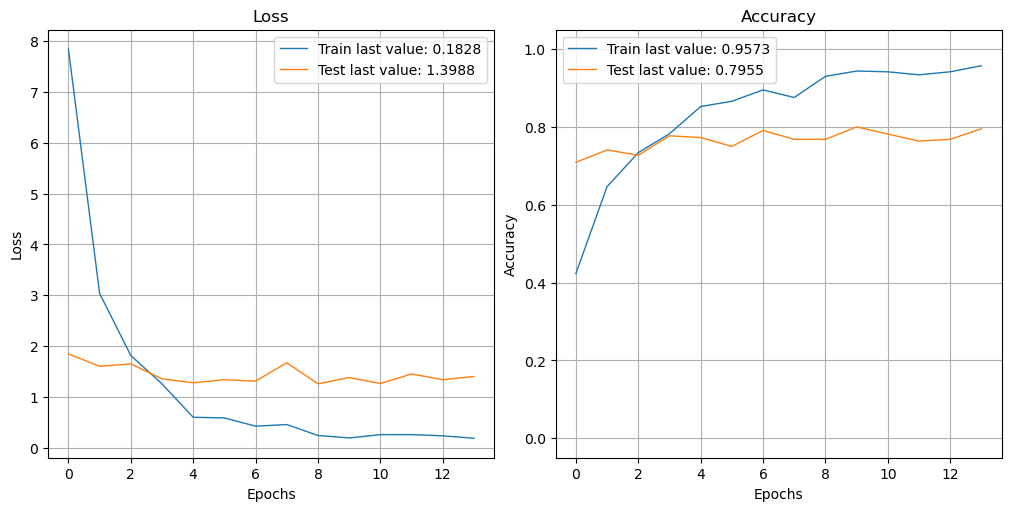

In [99]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

# Approche par dataset Tesnorflow avec Augmentation 

In [171]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

In [172]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [173]:
data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

In [174]:
model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
for layer in model_base.layers:
    layer.trainable = False

In [175]:
model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

In [176]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


In [177]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [178]:
# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [179]:
with tf.device('/gpu:0'): 
    history4 = model.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
16/17 [===========================>..] - ETA: 0s - loss: 1.8049 - accuracy: 0.3242
Epoch 1: val_loss improved from inf to 1.34707, saving model to .\model4_best_weights.h5
17/17 [==============================] - 13s 505ms/step - loss: 1.8032 - accuracy: 0.3243 - val_loss: 1.3471 - val_accuracy: 0.6500
Epoch 2/50
16/17 [===========================>..] - ETA: 0s - loss: 1.4246 - accuracy: 0.5156
Epoch 2: val_loss improved from 1.34707 to 1.05140, saving model to .\model4_best_weights.h5
17/17 [==============================] - 9s 496ms/step - loss: 1.4243 - accuracy: 0.5165 - val_loss: 1.0514 - val_accuracy: 0.7455
Epoch 3/50
16/17 [===========================>..] - ETA: 0s - loss: 1.1278 - accuracy: 0.6621
Epoch 3: val_loss improved from 1.05140 to 0.86878, saving model to .\model4_best_weights.h5
17/17 [==============================] - 9s 502ms/step - loss: 1.1261 - accuracy: 0.6621 - val_loss: 0.8688 - val_accuracy: 0.7773
Epoch 4/50
17/17 [==============================]

Epoch 20/50
16/17 [===========================>..] - ETA: 0s - loss: 0.4698 - accuracy: 0.8477
Epoch 20: val_loss did not improve from 0.58042
17/17 [==============================] - 9s 489ms/step - loss: 0.4685 - accuracy: 0.8485 - val_loss: 0.5807 - val_accuracy: 0.8318
Epoch 21/50
16/17 [===========================>..] - ETA: 0s - loss: 0.4693 - accuracy: 0.8691
Epoch 21: val_loss improved from 0.58042 to 0.57630, saving model to .\model4_best_weights.h5
17/17 [==============================] - 9s 491ms/step - loss: 0.4668 - accuracy: 0.8699 - val_loss: 0.5763 - val_accuracy: 0.8227
Epoch 22/50
17/17 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8835
Epoch 22: val_loss did not improve from 0.57630
17/17 [==============================] - 9s 498ms/step - loss: 0.4204 - accuracy: 0.8835 - val_loss: 0.6040 - val_accuracy: 0.7955
Epoch 23/50
16/17 [===========================>..] - ETA: 0s - loss: 0.4677 - accuracy: 0.8672
Epoch 23: val_loss did not improve fr

In [180]:
# Score du dernier epoch

loss, accuracy = model.evaluate(dataset_test, verbose=True)
print("Test Accuracy   : {:.4f}".format(accuracy))

10/10 [==============================] - 3s 159ms/step - loss: 0.3343 - accuracy: 0.8984
Test Accuracy   : 0.8984


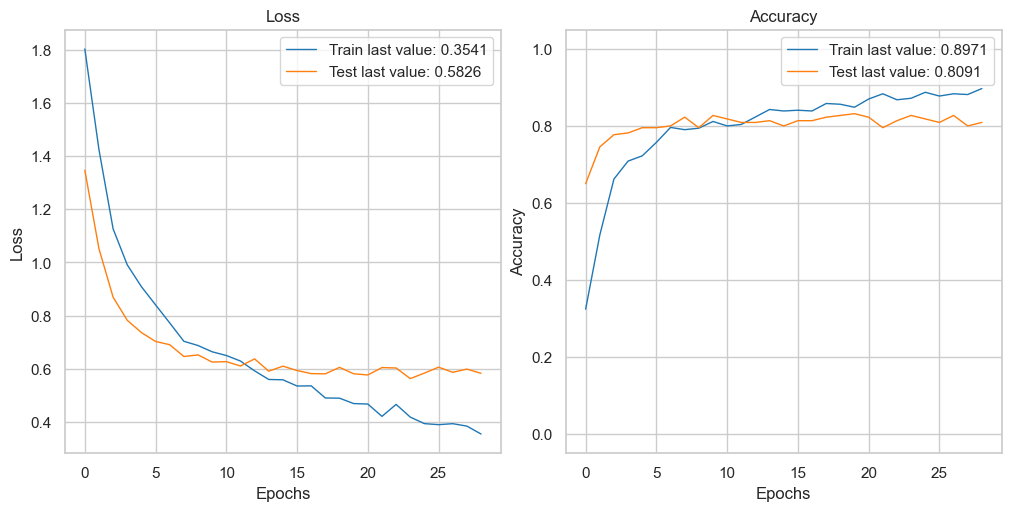

In [181]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()